In [ ]:
# Use this block of code when working on Google Colab in order to save the files in Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

#path = "drive/MyDrive/Thesis/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install and import the necesary libraries

In [ ]:
# Installation of libraries for Google Colab
# %pip install osmnx
# %pip install vt2geojson
# %pip install mercantile

In [1]:
# Import the necessary libraries for the functions
import osmnx as ox

import geopandas as gpd

from vt2geojson.tools import vt_bytes_to_geojson
from shapely.geometry import Point
from scipy.spatial import cKDTree
import mercantile

from tqdm import tqdm
import pandas as pd
import requests

from concurrent.futures import ThreadPoolExecutor
import json
import os

from PIL import Image

/Users/abril/opt/anaconda3/envs/ssml/lib/python3.10/site-packages/osmnx/projection.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
/Users/abril/opt/anaconda3/envs/ssml/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected ver

### Get the roads of the city

We use OSMnx to retrieve the road network of the selected city and save the result as a GeoPackage file.

In [2]:
def get_road_network(city, path=""):
    # Get the road network graph using OpenStreetMap data
    # 'network_type' argument is set to 'drive' to get the road network suitable for driving
    # 'simplify' argument is set to 'True' to simplify the road network
    G = ox.graph_from_place(city, network_type="drive", simplify=True)

    # Plot the road network graph using osmnx
    ox.plot_graph(G)

    # Project the graph from latitude-longitude coordinates to a local projection (in meters)
    G_proj = ox.project_graph(G)

    # Save the projected graph to a GeoPackage file
    ox.save_graph_geopackage(G_proj, filepath="{}data/{}/{} road.gpkg".format(path, city, city))

    return True

### Get the road edges and select the points

The previously saved GeoPackage file with the road network data is read to then create a list of points over the road map with a defined distance between them.

In [3]:
# Get a list of points over the road map with a N distance between them
def select_points_on_road_network(city, distance=50, path=""):
    # Load the saved GeoPackage file containing the road network graph
    path_to_file="{}data/{}/{} road.gpkg".format(path, city, city)
    gdf = gpd.read_file(path_to_file, layer="edges")

    # Define the distance between points that we want
    distance = 50

    # Initialize a list to store the points
    points = []

    # Loop through each road in the road network graph
    for road in gdf.geometry:
        # Calculate the total length of the road
        road_length = road.length

        # Start at the beginning of the road
        current_position = 0

        # Loop through the road, adding points every 50 meters
        while current_position < road_length:
            # Get the point on the road at the current position
            current_point = road.interpolate(current_position)

            # Add the curent point to the list of points
            points.append(current_point)

            # Increment the position by the desired distance
            current_position += distance
    
    # Convert the list of points to a GeoDataFrame
    gdf_points = gpd.GeoDataFrame(geometry=points)

    # Set the same CRS as the road dataframes for the points dataframe
    gdf_points.set_crs(gdf.crs, inplace=True)

    # Save the points GeoDataFrame to a GeoPackage file
    path_to_file="{}data/{}/{} points.gpkg".format(path, city, city)
    gdf_points.to_file(path_to_file, driver="GPKG", crs=gdf_points.crs)

    return True

### Get the features on the selected points on the roads

Here, we group the points by their corresponding tiles and download the tiles and extract the features for each group. Then, the features are mateched to each point and the results are saved as a GeoPackage file.

In [4]:
# This function extracts the features for a given tile
def get_features_for_tile(tile, access_token):
    tile_url = f"https://tiles.mapillary.com/maps/vtp/mly1_public/2/{tile.z}/{tile.x}/{tile.y}?access_token={access_token}"
    response = requests.get(tile_url)
    result = vt_bytes_to_geojson(response.content, tile.x, tile.y, tile.z, layer="image")
    return [tile, result]

In [13]:
def get_features_on_points(city, access_token, zoom=14, path=""):
    # Load the saved GeoPackage file containing the points
    path_to_file="{}data/{}/{} points.gpkg".format(path, city, city)
    gdf_points = gpd.read_file(path_to_file)

    # Transform the coordinate reference system to EPSG 4326
    gdf_points.to_crs(epsg=4326, inplace=True)

    # Add a new column to gdf_points that contains the tile coordinates for each point
    gdf_points['tile'] = [mercantile.tile(x, y, zoom) for x, y in zip(gdf_points.geometry.x, gdf_points.geometry.y)]

    # Group the points by their corresponding tiles
    groups = gdf_points.groupby('tile')

    # Download the tiles and extract the features for each group
    features = []
    
    for tile, _ in (pbar:= tqdm(groups, total=len(groups))):
        pbar.set_description(f"Downloading tiles")
        features.append(get_features_for_tile(tile, access_token))

    pd_features = pd.DataFrame(features, columns=["tile", "features"])

    # Compute distances between each feature and all the points in gdf_points
    feature_points = pd.DataFrame(
        [(Point(f["geometry"]["coordinates"]), f) for row in pd_features["features"] for f in row["features"]],
        columns=["geometry", "feature"]
    )
    feature_tree = cKDTree(feature_points["geometry"].apply(lambda p: [p.x, p.y]).tolist())
    _, indices = feature_tree.query(gdf_points["geometry"].apply(lambda p: [p.x, p.y]).tolist())

    # Select the closest feature for each point
    gdf_points["feature"] = feature_points.loc[indices, "feature"].tolist()

    # Convert results to geodataframe and save it to a csv file
    path_to_file="{}data/{}/{} points with features.gpkg".format(path, city, city)
    gdf_points['tile'] = gdf_points['tile'].astype(str)
    gdf_points.to_file(path_to_file, driver="GPKG", crs=gdf_points.crs)

    return True

### Download the images for each point

Finally, the images for each point are downloaded and saved locally.

In [28]:
def crop_panoramic_image(image_id, dir_path):
    # Open the panoramic image
    pano_image = Image.open("{}/{}.jpg".format(dir_path, image_id))

    # Get the dimensions of the panoramic image
    pano_width, pano_height = pano_image.size

    # Calculate the height of each part
    part_width = pano_width // 4
    part_height = pano_height // 4

    # Crop the panoramic image into 4 equal parts
    parts = []
    for i in range(4):
        left = i * part_width
        right = left + part_width
        part = pano_image.crop((left, 0, right, pano_height))
        parts.append(part)
    
    # Crop the height of the images from the previous step
    cropped_parts = []
    for part in parts:
        cropped_part = part.crop((0, part_height, part.size[0], part.size[1]-part_height))
        cropped_parts.append(cropped_part)
    
    # Resize each part to have a width of 1024 pixels
    resized_parts = []
    new_size = (1024, int((1024/part_width)*part_height))
    for part in cropped_parts:
        resized_part = part.resize(new_size)
        resized_parts.append(resized_part)

    # Save the cropped and resized parts as separate files
    for i, part in enumerate(resized_parts):
        filename = "{}/{}_{}.jpg".format(dir_path, image_id, i)
        part.save(filename)

In [61]:
# Download images in parallel
def download_image(image_metadata, city, path, access_token):
    header = {'Authorization': 'OAuth {}'.format(access_token)}

    image_id = image_metadata["properties"]["id"]
    image_width = "thumb_2048_url" if image_metadata["properties"]["is_pano"] else "thumb_1024_url"
    
    url = 'https://graph.mapillary.com/{}?fields={}'.format(image_id, image_width)
    response = requests.get(url, headers=header)
    data = response.json()
    image_url = data[image_width]
    
    dir_path = os.path.join(path, "images", city)
    with open(os.path.join(dir_path, "{}.jpg".format(image_id)), "wb") as handler:
        image_data = requests.get(image_url, stream=True).content
        handler.write(image_data)

        if image_width == "thumb_2048_url":
            crop_panoramic_image(image_id, dir_path)
    return image_id

### Check the code with Kampala, Uganda

In [28]:
# Get the roadnetwork of a specific city using OpenStreetMap data
city = "Kampala, Uganda"

# Set access token for mapillary
access_token = "MLY|6267906093323631|fba37c53726a386c951323ee5b9874bf"

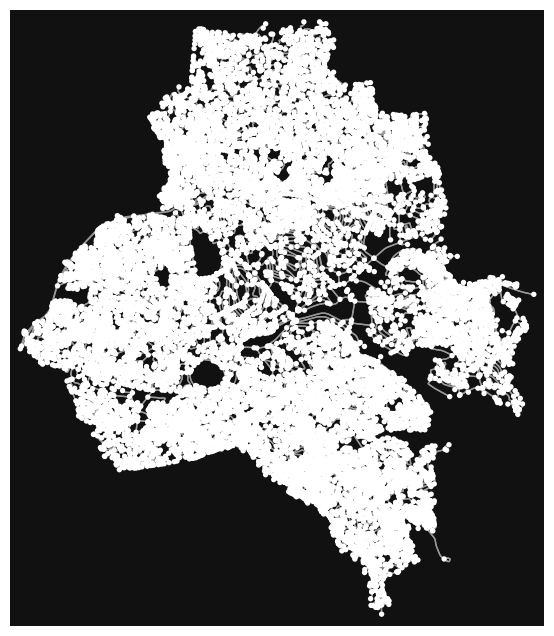

True

In [29]:
get_road_network(city)

In [33]:
select_points_on_road_network(city)

True

In [34]:
get_features_on_points(city, access_token)

  0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 44/44 [00:52<00:00,  1.18s/it]


True

### Use the code for Mexico City, Mexico

In [8]:
# Get the roadnetwork of a specific city using OpenStreetMap data
city = "Mexico City, Mexico"

# Set access token for mapillary
access_token = "MLY|6267906093323631|fba37c53726a386c951323ee5b9874bf"

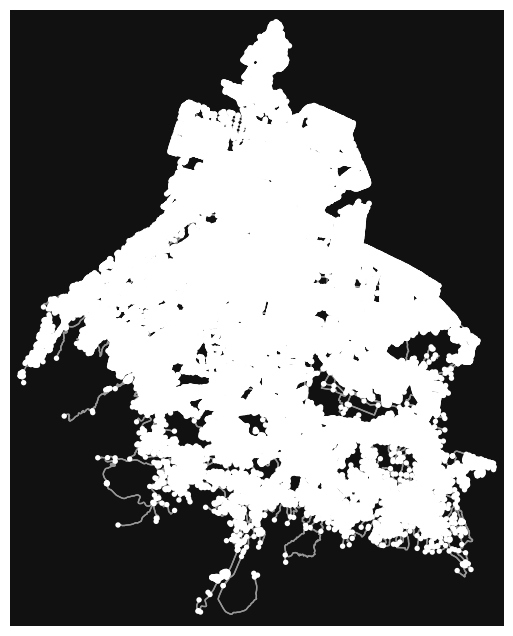

True

In [9]:
get_road_network(city)

In [10]:
select_points_on_road_network(city)

True

In [14]:
get_features_on_points(city, access_token)

True